В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%matplotlib inline

Remove warnings:

In [188]:
warnings.filterwarnings('ignore')

Вывод описания:

In [167]:
df_descr = pd.read_csv('otp_description.csv', sep='\t', encoding='utf8')
df_descr.head(3)

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,AGE,возраст клиента
2,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...


Читаем тестовую и обучающую выборки:

In [168]:
df_train = pd.read_csv('otp_train.csv', sep='\t', encoding='utf8')
df_test = pd.read_csv('otp_test.csv', sep='\t', encoding='utf8')
df_train.head(2).T.head(2)

,0,1
AGREEMENT_RK,59910150,59910230
TARGET,0,0


Создаем метки для тестовой и обучающей выборок:

In [169]:
df_train['sample'] = 'train'
df_test['sample'] = 'test'

Объединяем два сета:

In [170]:
df = df_test.append(df_train).reset_index(drop=True)

Посмотрим типы данных и их заполняемость

In [114]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Columns: 53 entries, AGREEMENT_RK to sample
dtypes: float64(2), int64(32), object(19)
memory usage: 12.2+ MB


Форматирование атрибута и конвертация в строковый формат:

In [115]:
df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float').head(1)

0    7000.0
Name: PERSONAL_INCOME, dtype: float64

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Заполните их нулями

Вывод атрибутов с пропусками:

In [116]:
for i in df.columns[df.isna().any()].tolist():
    print('+', i)

+ GEN_INDUSTRY
+ GEN_TITLE
+ ORG_TP_STATE
+ ORG_TP_FCAPITAL
+ JOB_DIR
+ TP_PROVINCE
+ REGION_NM
+ WORK_TIME
+ PREVIOUS_CARD_NUM_UTILIZED


Заполняем пропуски нулями:

In [117]:
df.fillna(0, inplace = True) 

#### Задание 2. В данных есть признаки, которые можно назвать категориальным. Конвертируйте в идентификаторы.

Выводим срез данных:

In [231]:
df[df.select_dtypes(['object']).columns].head(1).T

,0
EDUCATION,Среднее специальное
MARITAL_STATUS,Не состоял в браке
GEN_INDUSTRY,Образование
GEN_TITLE,Специалист
ORG_TP_STATE,Государственная комп./учреж.
ORG_TP_FCAPITAL,Без участия
JOB_DIR,Участие в основ. деятельности
FAMILY_INCOME,от 10000 до 20000 руб.
PERSONAL_INCOME,7000
REG_ADDRESS_PROVINCE,Красноярский край


Конвертируем некатегориальные признаки, которые неправильно интерпретированы в тип float:

In [119]:
non_cat = ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
df[non_cat] = df[non_cat].applymap(lambda x: x.replace(',', '.')).astype('float')

Конвертируем оставшиеся признаки в категориальные признаки и делаем кодировку:

In [120]:
df[df.select_dtypes(['object']).columns] = df[df.select_dtypes(['object']).columns].astype('category')
df[df.select_dtypes(['category']).columns] = df[df.select_dtypes(['category']).columns].apply(lambda x: x.cat.codes)

#### Задание 3. Фунция предобработки

Напишите функцию, которая выполняет следующие операции:

* Удаляет идентификатор `AGREEMENT_RK`
* Заменяет '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Обрабатывает пропуски 
* Кодирует категориальные признаки

Определяем функцию:

In [171]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    del df_output['AGREEMENT_RK'] #remove feature
    df_output.fillna(0, inplace = True) #remove nas
    
    non_cat = ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
    df_output[non_cat] = df_output[non_cat].applymap(lambda x: x.replace(',', '.')).astype('float')
    
    object_cols = df_output.select_dtypes(['object']).columns
    df_output[object_cols] = df_output[object_cols].astype('category')
    
    category_cols = df_output.select_dtypes(['category']).columns
    df_output[category_cols] = df_output[category_cols].apply(lambda x: x.cat.codes)
    
    return df_output

Применение функции:

In [172]:
df_preproc = df.pipe(preproc_data)

#### Задание 4. Напишите код, который разделит df_preproc на 2 части train и test 

In [173]:
df_train_preproc = df_preproc[df_preproc['sample']==0]  
df_test_preproc = df_preproc[df_preproc['sample']==1]

Удаляем столбец sample:

In [174]:
del df_test_preproc['sample']
del df_train_preproc['sample']

#### Задание 5. Отделите целевую переменную и остальные признаки (речь не про train_test_split)

In [180]:
X = df_train_preproc.drop('TARGET', axis=1)
X_valid = df_test_preproc.drop('TARGET', axis=1)

y = df_train_preproc['TARGET']
y_valid = df_test_preproc['TARGET']

#### Задание 6. Обучение и оценка качества разных моделей

In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  

Пробуем различные модели:

In [189]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pred_1 = DecisionTreeClassifier().fit(X_train, y_train).predict(X_test)
pred_2 = RandomForestClassifier().fit(X_train, y_train).predict(X_test)
pred_3 = LogisticRegression().fit(X_train, y_train).predict(X_test)

Считаем метрики:

In [269]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pr, ac = [], []
rc, f1 = [], []

for i in [pred_1, pred_2, pred_3]:
    
    ac.append(accuracy_score(y_test, i))
    pr.append(precision_score(y_test, i))
    rc.append(recall_score(y_test, i))
    f1.append(f1_score(y_test, i))

Отображаем метрики на графике:

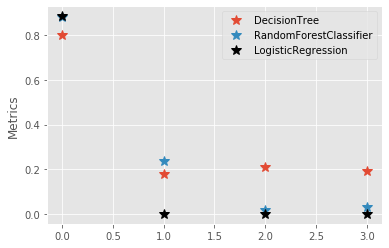

In [285]:
plt.plot([ac[0], pr[0], rc[0], f1[0]], '*', markersize=10, label='DecisionTree')
plt.plot([ac[1], pr[1], rc[1], f1[1]], '*', markersize=10, label='RandomForestClassifier')
plt.plot([ac[2], pr[2], rc[2], f1[2]], '*', markersize=10, label='LogisticRegression', color='black')

plt.grid(True)
plt.ylabel('Metrics')
plt.legend(loc='upper right')
plt.show()

#### Задание 7. Заключительное.
Выше вы можете выборать самую лучшую модель "коробочку" по метрике F1. Теперь вы знаете какой тип коробочки из представленных лучше всего работает на данной задаче. Пора: 1) заново объявить эту коробочку 2) обучить на всем X,y 3) протестировать на отложенном X_valid, y_valid.

In [294]:
pred_final=DecisionTreeClassifier().fit(X, y).predict(X_valid )

print('Accuracy: ', round(accuracy_score(y_valid, pred_final),2))
print('Precision: ', round(precision_score(y_valid, pred_final),2))
print('Recall: ', round(recall_score(y_valid, pred_final), 2))
print('F1: ', round(f1_score(y_valid, pred_final), 2))

Accuracy:  0.79
Precision:  0.16
Recall:  0.18
F1:  0.17
